# Secrets behind recipes

Team member: Tianyang Dong, Wei Jiang, Huajian Qiu, Jiahua Wu

---
## 0 Import libraries and recipe dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import inflect 
from wordcloud import WordCloud, STOPWORDS 

In [2]:
recipe = pd.read_csv('data/RAW_recipes.csv')

In [3]:
recipe.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [4]:
recipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
name              231636 non-null object
id                231637 non-null int64
minutes           231637 non-null int64
contributor_id    231637 non-null int64
submitted         231637 non-null object
tags              231637 non-null object
nutrition         231637 non-null object
n_steps           231637 non-null int64
steps             231637 non-null object
description       226658 non-null object
ingredients       231637 non-null object
n_ingredients     231637 non-null int64
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


---

# 1 Data cleaning of recipes

## 1.1 Map recipe to countries (regions) and continents

First, drop the rows that have nan values on column 'name'. Since 'description' is irrelavent to our analysis, we will not deal with the missing values in column 'description'.

The information about country/region is extracted from the tags, for example, there are tags like 'american', 'southern-united-states', 'scottish'. These tags will be mapped to countries if they describes a part of a country, e.g. 'southern-united-states' to 'America', otherwise they will be mapped to a region, e.g. 'caribbean' to 'Caribbean'. Later the countries will be mapped to continents.

In the end, we get 96717 rows of recipes with country labeled.

In [5]:
recipe.drop(index = recipe[recipe['name'].isna()].index, inplace = True)

In [6]:
recipe['tags'] = recipe['tags'].apply(ast.literal_eval)

In [7]:
recipe_tag = recipe.explode('tags')

In [8]:
recipe_tag['tags'].unique()

array(['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient',
       'cuisine', 'preparation', 'occasion', 'north-american',
       'side-dishes', 'vegetables', 'mexican', 'easy', 'fall',
       'holiday-event', 'vegetarian', 'winter', 'dietary', 'christmas',
       'seasonal', 'squash', '30-minutes-or-less', 'breakfast',
       'main-dish', 'pork', 'american', 'oven', 'kid-friendly', 'pizza',
       'northeastern-united-states', 'meat', 'equipment', 'chili',
       'crock-pot-slow-cooker', '4-hours-or-less', 'eggs-dairy',
       'potatoes', 'dinner-party', 'easter', 'cheese', 'stove-top',
       'new-years', 'thanksgiving', 'independence-day', 'st-patricks-day',
       'valentines-day', 'inexpensive', 'brunch', 'superbowl',
       'presentation', 'served-hot', 'weeknight', 'canning',
       'condiments-etc', 'heirloom-historical', 'amish-mennonite',
       'number-of-servings', 'technique', '15-minutes-or-less',
       'low-protein', '5-ingredients-or-less', 'beverages', '

In [9]:
union = ['austrilian', 'chinese', 'korean','american', 
               'japanese', 'thai', 'italian', 'french', 'danish', 
               'swiss', 'swedish','german', 'namibian', 'argentine', 'nigerian', 'norwagian',
             'new-zealand', 'lebanese','mexican', 'irish', 'canadian', 'hawaiian', 
             'indonesian', 'polish', 'caribbean', 'russian', 'iraqi', 'saudi-arabian', 'pakistani', 'scottish',
             'south-african', 'cuban', 'columbian', 'finnish', 'iranian-persian', 'dutch', 'turkish', 
              'portuguese', 'hungarian', 'georgian','brazilian', 'nigerian',  'egyptian', 'chilean',
             'vietnamese', 'palestinian', 'austrian', 'caribbean', 'greek', 'micro-melanesia','polynesian',
             'spanish', 'malaysian', 'namibian', 'angolan','belgian', 'cambodian','british-columbian',
        'californian', 'cantonese', 'central-american', 'chinese-new-year', 'costa-rican', 'czech',
    'ethiopian','filipino','honduran','hunan','icelandic',  'irish-st-patricks-day','laotian',
    'libyan', 'mongolian','moroccan','native-american',
    'north-american','northeastern-united-states','oaxacan', 'ontario', 'quebec','puerto-rican', 'somalian', 
    'southern-united-states','sudanese', 'szechuan','welsh', 'venezuelan', 'indian', 'australian']

In [10]:
dic = {'mexican': 'Mexico',
'american': 'America',
'canadian': 'Canada',
'hawaiian': 'Hawaii',
'german': 'Germany',
'italian': 'Italy',
'polish': 'Poland',
'danish': 'Denmark',
'swiss': 'Switzerland',
'swedish': 'Sweden',
'caribbean': 'Caribbean',
'greek': 'Greece',
'russian': 'Russia',
'micro-melanesia': 'Melanesia',
'spanish': 'Spain',
'irish': 'Ireland',
'scottish': 'UK',
'south-african': 'South Africa',
'new-zealand': 'New Zealand',
'finnish': 'Finland',
'dutch': 'Netherlands',
'portuguese': 'Portugal',
'hungarian': 'Hungary',
'brazilian': 'Brazil',
'nigerian': 'Niger',
'egyptian': 'Egypt',
'argentine': 'Argentina',
'chilean': 'Chile',
'chinese': 'China',
'saudi-arabian': 'Saudi Arabia',
'turkish': 'Turkey',
'japanese': 'Japan',
'austrian': 'Austria',
'palestinian': 'Palestine',
'lebanese': 'Lebanon',
'thai': 'Thailand',
'indonesian': 'Indonesia',
'italian': 'Italy',
'pakistani': 'Pakistan',
'cuban': 'Cuba',
'malaysian': 'Malaysia',
'vietnamese': 'Vietnam',
'palestinian': 'Palestine',
'namibian': 'Namibia',
'iranian-persian': 'Iran',
'polynesian': 'Polynesia',
'iraqi': 'Iraq',
'georgian': 'Georgia',
'korean': 'Korea',
'french': 'France' ,
'english': 'England',
'austrilian': 'Austrilia',
'norwagian': 'Norway',
'angolan': 'Angola',
'belgian': 'Belgium', 
'cambodian': 'Cambodia',
'british-columbian': 'Canada', 
'californian': 'America', 
'cantonese': 'China', 
'central-american': 'America', 
'chinese-new-year': 'China', 
'costa-rican': 'Costa Rica', 
'czech': 'Czechia',
'ethiopian': 'Ethiopia',
'filipino': 'Philippines',
'honduran': 'Honduras',
'hunan': 'China',
'icelandic': 'Iceland',  
'irish-st-patricks-day': 'Ireland',
'laotian': 'Lao',
'libyan': 'Lybia', 
'mongolian': 'Mongolia',
'moroccan': 'Morocca',
'native-american': 'America',
'north-american': 'America',
'northeastern-united-states': 'America',
'oaxacan': "Mexico", 
'ontario': 'Canada', 
'quebec': 'Canada',
'puerto-rican': 'Caribbean', 
'somalian': 'Somalia', 
'southern-united-states': 'America', 
'sudanese': 'Sudan', 
'szechuan': 'China',
'welsh': 'UK', 
'venezuelan': 'Venezuela',
'indian': 'India',
'australian': 'Australia'}


In [11]:
dic_cc = {'Mexico': 'North America',
'America':'North America',
'Canada':'North America',
'Hawaii':'North America',
'Germany': 'Europe',
'Italy':'Europe',
'Poland':'Europe',
'Denmark':'Europe',
'Switzerland':'Europe',
'Sweden':'Europe',
'Caribbean':'North America',
'Greece':'Europe',
'Russia':'Europe',
'Melanesia':'Oceania',
'Spain':'Europe',
'Ireland':'Europe',
'UK':'Europe',
'South Africa':'Africa',
'New Zealand':'Oceania',
'Finland':'Europe',
'Netherlands':'Europe',
'Portugal':'Europe',
'Hungary':'Europe',
'Brazil':'South America',
'Niger':'Africa',
'Egypt': 'Africa',
'Argentina': 'South America',
'Chile':'South America',
'China':'Asia',
'Saudi Arabia': 'Asia',
'Turkey':'Asia',
'Japan':'Asia',
'Austria':'Europe',
'Palestine':'Asia',
'Lebanon':'Asia',
'Thailand':'Asia',
'Indonesia':'Asia',
'Pakistan':'Asia',
'Cuba':'South America',
'Malaysia':'Asia',
'Vietnam':'Asia',
'Namibia':'Africa',
'Iran':'Asia',
'Polynesia': 'Oceania',
'Iraq':'Asia',
'Georgia':'Europe',
'Korea':'Asia',
'France' :'Europe',
'England':'Europe',
'Austrilia':'Oceania',
'Norway': 'Europe',
'Angola': 'Africa',
'Belgium': 'Europe',
'Cambodia': 'Asia',
'Costa Rica': 'North America',
'Czechia': 'Europe',
'Ethiopia': 'Africa',
'Philippines': 'Asia',
'Honduras': 'North America',
'Iceland': 'Europe',
'Lao': 'Asia',
'Lybia': 'Africa',
'Mongolia': 'Asia',
'Morocca': 'Africa',
'Somalia': 'Africa', 
'Venezuela': 'South America',
'Sudan': 'Africa',
'India': 'Asia',
'Australia': 'Oceania'
}

In [12]:
recipe_country =  recipe_tag[recipe_tag['tags'].isin(union)]

In [13]:
recipe_country.insert(2, "country", recipe_country['tags'].map(dic), True) 

In [ ]:
recipe_country.drop(columns = 'tags', inplace=True)

In [ ]:
recipe_country.reset_index(drop = True, inplace = True)
recipe_country.drop_duplicates(inplace = True)

In [16]:
recipe_country.insert(3, "continent", recipe_country['country'].map(dic_cc), True) 

In [17]:
recipe_country.head()

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,arriba baked winter squash mexican style,137739,Mexico,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
5,amish tomato ketchup for canning,44061,America,North America,190,41706,2002-10-25,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
8,apple a day milk shake,5289,America,North America,0,1533,1999-12-06,"[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4


In [18]:
recipe_country.to_pickle('recipe_country.pkl')

## 1.2 Classify recipes by meal types

To better understand the difference between countires and regions, we divide the recipes into classes: main dish, side dish, dessert, appetizer, soup, beverage, cake style (bread, sandwich and cake), sauce, salad and snack. These classes are not mutually exclusive, so there may be a recipe in two classes at the same time. The information about dish type is gained from tags of recipes.

This type specified dataframe will be used later for analyzing the ingredients and answer questions like: what is the most frequently used meat for main dish in each country?

In [19]:
main_dish = recipe_tag[recipe_tag['tags'].str.contains('main-dish')][['id', 'tags']]

In [20]:
main_dish.rename(columns = {'tags':'main_dish'}, inplace = True)

In [21]:
side_dish = recipe_tag[recipe_tag['tags'].str.contains('side-dishes')][['id', 'tags']]
side_dish.rename(columns = {'tags':'side_dish'}, inplace = True)

In [22]:
dessert = recipe_tag[recipe_tag['tags'].str.contains('dessert')][['id', 'tags']]
dessert.rename(columns = {'tags':'dessert'}, inplace = True)

In [23]:
appetizer = recipe_tag[recipe_tag['tags'].str.contains('appetizer')][['id', 'tags']]
appetizer.rename(columns = {'tags':'appetizer'}, inplace = True)

In [24]:
soup = recipe_tag[recipe_tag['tags'].str.contains('soup|stew')][['id', 'tags']]
soup.rename(columns = {'tags':'soup'}, inplace = True)

In [25]:
beverage = recipe_tag[recipe_tag['tags'].str.contains('beverage')][['id', 'tags']]
beverage.rename(columns = {'tags':'beverage'}, inplace = True)

In [26]:
cake_style = recipe_tag[recipe_tag['tags'].str.contains('sandwich|bread|cake')][['id', 'tags']]
cake_style.rename(columns = {'tags':'cake_style'}, inplace = True)

In [27]:
sauce = recipe_tag[recipe_tag['tags'].str.contains('sauce')][['id', 'tags']]
sauce.rename(columns = {'tags':'sauce'}, inplace = True)

In [28]:
salad = recipe_tag[recipe_tag['tags'].str.contains('salad')][['id', 'tags']]
salad.rename(columns = {'tags':'salad'}, inplace = True)

In [29]:
snack = recipe_tag[recipe_tag['tags'].str.contains('snack')][['id', 'tags']]
snack.rename(columns = {'tags':'snack'}, inplace = True)

In [30]:
recipe_s = recipe_country.merge(main_dish, on = 'id', how = 'left'
                    ).merge(side_dish, on = 'id', how = 'left').merge(dessert, on = 'id', how = 'left',
                    ).merge(appetizer, on = 'id', how = 'left').merge(soup, on = 'id', how = 'left'
                                            ).merge(beverage, on = 'id', how = 'left'
                                                   ).merge(cake_style, on = 'id', how = 'left'
                                                          ).merge(sauce, on = 'id', how = 'left'
                                         ).merge(salad, on = 'id', how = 'left').merge(
                                                snack, on = 'id', how = 'left')

In [31]:
recipe_s['main_dish'] = recipe_s['main_dish'].notnull().astype('int')

In [32]:
recipe_s['side_dish'] = recipe_s['side_dish'].notnull().astype('int')
recipe_s['dessert'] = recipe_s['dessert'].notnull().astype('int')
recipe_s['appetizer'] = recipe_s['appetizer'].notnull().astype('int')

In [33]:
recipe_s['soup'] = recipe_s['soup'].notnull().astype('int')
recipe_s['beverage'] = recipe_s['beverage'].notnull().astype('int')

In [34]:
recipe_s['cake_style'] = recipe_s['cake_style'].notnull().astype('int')

In [35]:
recipe_s['sauce'] = recipe_s['sauce'].notnull().astype('int')
recipe_s['salad'] = recipe_s['salad'].notnull().astype('int')
recipe_s['snack'] = recipe_s['snack'].notnull().astype('int')

In [36]:
recipe_s.drop_duplicates(inplace = True)

In [37]:
recipe_s.shape

(96717, 23)

The recipes that are not labeled among the given classes are deleted. 86657 rows are left.

In [38]:
recipe_split = recipe_s[recipe_s.iloc[:, 13:].sum(axis = 1) > 0]

In [39]:
recipe_split.head()

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,...,main_dish,side_dish,dessert,appetizer,soup,beverage,cake_style,sauce,salad,snack
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",...,0,1,0,0,0,0,0,0,0,0
1,arriba baked winter squash mexican style,137739,Mexico,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",...,0,1,0,0,0,0,0,0,0,0
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",...,1,0,0,0,0,0,0,0,0,0
4,apple a day milk shake,5289,America,North America,0,1533,1999-12-06,"[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",...,0,0,0,0,0,1,0,0,0,0
5,aww marinated olives,25274,America,North America,15,21730,2002-04-14,"[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,...,0,0,0,1,0,0,0,0,0,0


## 1.3 Extract seasoning for each recipe

In the column 'ingredients', all the ingredients need by the recipe are listed. To learn in detail about each country's eating habits, we investigate two aspects of the ingredients: seasoning and main ingredients. Here we  refer seasoning as those that are used to adjust the flavor of the dish, like curry, parsley and so on. While main ingredients are those that are added in the dish for the purpose of eating, e.g. beef, egg. The extraction of main ingredients are done in Section 1.5

The seasoning list is collceted through searching on Google. 48 different seasonings are identified. The classification is rather coarse: 'pepper sauce', 'red pepper', 'green peppers' are considered to be the same as 'pepper'. 'brown sugar', 'white sugar', 'maple sugar' are in the same class 'sugar'. It will be way too complicated and less general if we specify all kinds of 'pepper', 'sugar', etc. Several special cases are handled specifically, for example, the plurals of seasonings, 'olive oil' and 'olive', 'sugar-free' and 'salt-free', etc. 


In [40]:
recipe_c = recipe_country.copy()
recipe_c['ingredients'] = recipe_c['ingredients'].apply(eval)
recipe_ingre = recipe_c.explode('ingredients')

In [41]:
seasoning = ['salt', 'sugar','cheese', 'butter', 'spice','pepper','chili', 'onion','garlic', 'oil',
             'ginger','vineger','clove', 'herb','mayonnaise','vanilla','honey', 'cinnamon', 'curry',
            'mustard', 'olive', 'basil', 'oregano', 'sesame', 'thyme','paprika', 'cajun', 'cardamom',
            'sage', 'rosemary','nutmeg', 'parsley', 'coriander', 'bay', 'cumin', 'tarragon','allspice',
            'cayenne', 'anise', 'celery', 'dill', 'wasabi', 'mace', 'syrup', 'cilantro',
            'salts', 'spices', 'peppers', 'chilis', 'onions', 'cloves', 'herbs', 'olives', 'nutmegs']

In [42]:
def judge_seasoning(row):
    s_list = re.findall(r"[\w']+", row)
    r_list = []
    for i in range(len(s_list)):
        if s_list[i] in seasoning:
            if (s_list[i] == 'olive') & (len(s_list) > i+1):
                if s_list[i+1] == 'oil':
                    continue
                else:
                    r_list.append(s_list[i])
            elif (len(s_list) > i+1):
                if s_list[i+1] == 'free':
                    continue
                else:
                    r_list.append(s_list[i])
            elif (s_list[i] == 'coy') & (len(s_list) > i+1):
                if s_list[i+1] == 'sauce':
                    r_list.append('soy sauce')
            elif (s_list[i] == 'tomato') & (len(s_list) > i+1):
                if s_list[i+1] == 'sauce':
                    r_list.append('tomato sauce')
            else:
                r_list.append(s_list[i])
    return str(r_list)

In [43]:
recipe_ingre['seasoning'] = recipe_ingre['ingredients'].apply(judge_seasoning)

In [44]:
recipe_ingre['seasoning'] = recipe_ingre['seasoning'].apply(ast.literal_eval)

In [45]:
recipe_ingre.reset_index(drop = True, inplace = True)
recipe_ingre.drop(index = recipe_ingre[recipe_ingre['seasoning'].apply(len) == 0].index, inplace = True)

In [46]:
recipe_ingre.head()

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients,seasoning
2,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,mixed spice,7,[spice]
3,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,honey,7,[honey]
4,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,butter,7,[butter]
5,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,olive oil,7,[oil]
6,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,salt,7,[salt]


In [47]:
recipe_seasoning = recipe_ingre.explode('seasoning')

In [48]:
recipe_seasoning.reset_index(drop = True, inplace = True)

In [49]:
recipe_seasoning.drop(index = recipe_seasoning[recipe_seasoning['seasoning'].isna()].index, inplace = True)

In [50]:
recipe_seasoning.head()

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients,seasoning
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,mixed spice,7,spice
1,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,honey,7,honey
2,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,butter,7,butter
3,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,olive oil,7,oil
4,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,salt,7,salt


In [51]:
dic_season = {}
for i in seasoning:
    if i[-1] != 's':
        dic_season[i] = i
    else:
        dic_season[i] = i[:-1]

In [52]:
recipe_seasoning['seasoning'] = recipe_seasoning['seasoning'].map(dic_season)

In [53]:
recipe_seasoning.drop_duplicates(inplace = True)

In [54]:
recipe_seasoning.head()

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients,seasoning
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,mixed spice,7,spice
1,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,honey,7,honey
2,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,butter,7,butter
3,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,olive oil,7,oil
4,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,salt,7,salt


Top 20 frequently used seasoning for each country is computed.

In [55]:
season_country = recipe_seasoning.groupby(['country', 'seasoning'])['id'].count().groupby('country').nlargest(20)

In [56]:
season_country = season_country.to_frame().droplevel(0).reset_index()  

#### Here we show the Mexican's top 20 most frequently used seasonings  as an example. Word cloud is a popular tool for showing word frequencies and it is used to visualize the result.

In [57]:
season_country[season_country['country'] == 'Mexico']

,country,seasoning,id
796,Mexico,pepper,5226
797,Mexico,onion,4339
798,Mexico,salt,3680
799,Mexico,cheese,3651
800,Mexico,garlic,3191
801,Mexico,oil,2453
802,Mexico,cilantro,1887
803,Mexico,cumin,1844
804,Mexico,clove,1822
805,Mexico,chili,1749


In [58]:
recipe_seasoning.to_pickle('recipe_seasoning.pkl', compression='gzip')

In [59]:
def plt_wordcloud(data_list):
    word = ''
    for val in data_list: 
    # typecaste each val to string 
        val = str(val)     
        word += val + ' '
    stopwords = set(STOPWORDS) 

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    collocations = False,
                    min_font_size = 10).generate(word) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

In [60]:
data = recipe_seasoning[recipe_seasoning['country'] == 'Mexico']['seasoning'].values

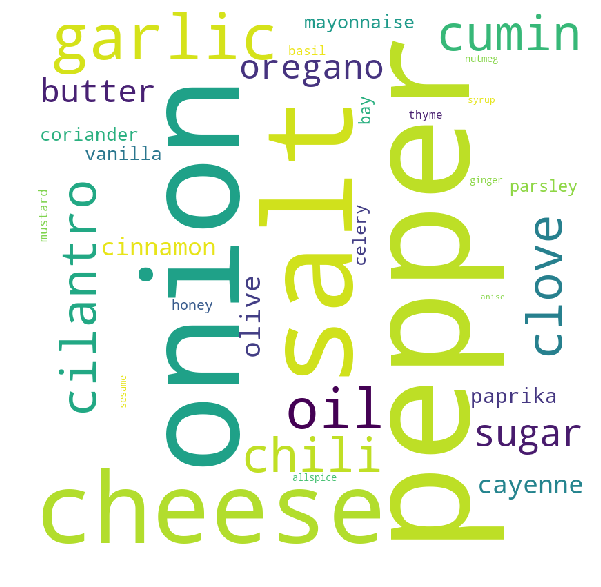

In [61]:
plt_wordcloud(data)

## 1.4 Extract cooking methods for each recipe

Beside the ingredients, cooking method also varies across country. When 'boiling eggs' or 'frying eggs', the ingredients used are the same, yet the look, the smell and the flavor of the dishes are distinct. In this section we extract cooking methods from column 'steps' from the dataframe.

In [62]:
method_list = [
    'bake',
    'barbecue',
    'blanch',
    'blend',
    'boil',
    'braise',
    'brine',
    'broil',
    'caramelize',
    'combine',
    'crock pot',
    'crush',
    'deglaze',
    'devein',
    'dice',
    'distill',
    'drain',
    'emulsify',
    'ferment',
    'freez',
    'fry',
    'grate',
    'griddle',
    'grill',
    'knead',
    'leaven',
    'marinate',
    'mash',
    'melt',
    'microwave',
    'parboil',
    'pickle',
    'poach',
    'pour',
    'pressure cook',
    'puree',
    'refrigerat',
    'roast',
    'saute',
    'scald',
    'scramble',
    'shred',
    'simmer',
    'skillet',
    'slow cook',
    'smoke',
    'smooth',
    'soak',
    'sous-vide',
    'steam',
    'stew',
    'strain',
    'tenderize',
    'thicken',
    'toast',
    'toss',
    'whip',
    'whisk']

In [63]:
recipe_cooking = recipe_country.copy()

In [64]:
recipe_cooking['steps'] = recipe_cooking['steps'].apply(ast.literal_eval)

In [65]:
def judge_cooking(row):
    r_list = set([])
    for stc in row:
        s_list = re.findall(r"[\w']+", stc)
        for word in s_list:
            if word in method_list:
                r_list.add(word)
    return list(r_list)

In [66]:
recipe_cooking['method'] = recipe_cooking['steps'].apply(judge_cooking)

In [67]:
recipe_cooking.reset_index(drop = True, inplace = True)

In [68]:
recipe_cooking.drop(index = recipe_cooking[recipe_cooking['method'].apply(len) == 0].index, inplace = True)   

In [69]:
recipe_cooking.head()

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients,method
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,[bake]
1,arriba baked winter squash mexican style,137739,Mexico,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,[bake]
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,"[pour, bake, whisk]"
3,amish tomato ketchup for canning,44061,America,North America,190,41706,2002-10-25,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"[mix all ingredients& boil for 2 1 / 2 hours ,...",my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,"[boil, pour]"
4,apple a day milk shake,5289,America,North America,0,1533,1999-12-06,"[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"[combine ingredients in blender, cover and ble...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4,"[combine, smooth, blend]"


In [70]:
recipe_cooking.to_pickle('recipe_cooking.pkl')

In [71]:
recipe_cooking_e = recipe_cooking.explode('method')

In [72]:
method_country = recipe_cooking_e.groupby(['country', 'method'])['id'].count().groupby('country').nlargest(10)
method_country = method_country.to_frame().droplevel(0).reset_index()  

#### American cooking method wordcloud

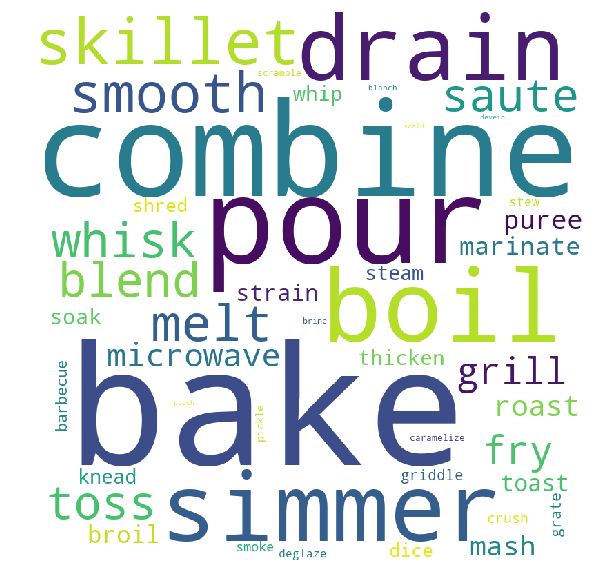

In [73]:
data = recipe_cooking_e[recipe_cooking_e['country'] == 'America']['method'].values
plt_wordcloud(data)

#### Chinese cooking method wordcloud

In [74]:
data = recipe_cooking_e[recipe_cooking_e['country'] == 'China']['method'].values

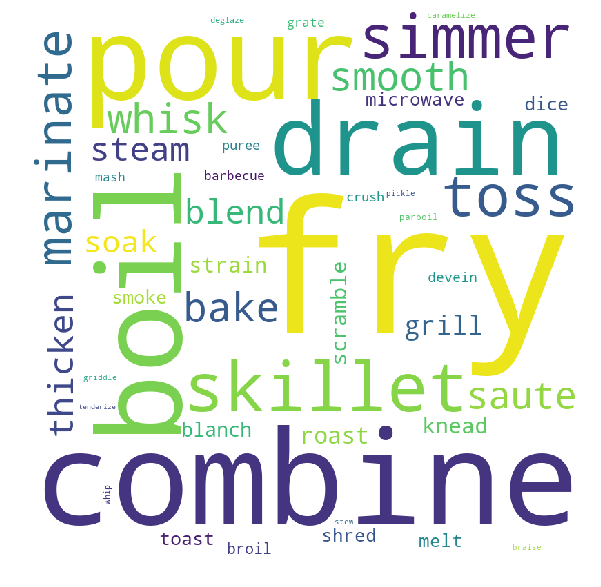

In [75]:
plt_wordcloud(data)

The top 10 most frequenly used cooking methods of American and Chinese are shown in a wordcloud below. The most popular way for Chinese is to fry, which coincides with our expectation. We can see that 'microwave' and 'bake' is not popular in China, because these methods are not traditional Chinese cooking methods. While for Americans, they are used to 'baking' things, and 'fry' will not be their top choice when cooking.

## 1.5 Extract main ingredients for each recipe

As mentioned in section 1.3, main ingredients are extracted. The categoreis (dairy, grain, vegetable, fruit, meat, seafood) are collected from supercook (https://www.supercook.com/#/recipes). 220 various ingredients are identified. 

In [76]:
dairy = ['egg', 'milk', 'cream', 'yogurt', 'frosting'] 
grain = ['rice', 'pasta', 'flour', 'bread', 'tortilla', 'pancake', 'pie', 'pizza']
vegetable = ['tomato', 'potato', 'carrot',
              'broccoli', 'corn', 'spinach', 'mushroom', 'beans', 'salad green', 'cucumber',
              'pickle', 'avocado', 'zucchini', 'cilantro', 'frozen vegetable', 'asparagus',
             'cabbage', 'cauliflower', 'kale', 'mixed vegetable', 'pumpkin', 'squash', 'scallion',
             'shallot', 'eggplant', 'beet', 'horseradish', 'leek', 'caper', 'brussels sprout',
             'artichoke', 'chia', 'radish', 'sauerkraut', 'artichoke', 'arugula', 'capsicum',
             'bok choy', 'parsnip', 'okra', 'yam', 'fennel', 'turnip', 'pea', 'seaweed', 'chard', 'collard',
             'pimiento', 'watercress', 'tomatillo', 'rocket' 'bamboo shoot', 'rutabaga', 'endive',
              'jicama',  'kohlrabi', 'palm', 'butternut', 'daikon', 'radicchio', 'porcini', 'jerusalem artichoke'
             'cress', 'chestnut', 'dulse', 'micro green', 'burdock', 'chayote']
fruit = ['lemon', 'apple', 'banana', 'lime', 'strawberry', 'orange', 'pineapple', 'blueberry', 
             'raisin', 'coconut', 'grape', 'peach', 'cranberry', 'mango', 'pear', 'blackberry', 'cherry',
        'watermelon', 'kiwi', 'grapefruit', 'mandarin', 'craisins', 'cantaloupe', 'plum', 'apricot',
         'clementine', 'prune', 'apple butter', 'pomegranate', 'nectarine', 'fig', 'tangerine', 'papaya',
         'rhubarb', 'sultana', 'plantain', 'currant', 'passion fruit', 'guava', 'persimmon', 'lychee',
         'lingonberry', 'tangelo', 'kumquat', 'boysenberry', 'star fruit', 'quince', 'honeydew', 'crabapple']
meat = ['chicken', 'beef', 'bacon', 'sausage', 'steak', 'ham', 'hot dog', 'pork', 'turkey', 'pepperoni',
       'salami', 'spam', 'venison','bologna', 'bratwurst', 'prosciutto', 'lamb', 'pancetta', 'duck', 'veal',
        'cornish hen', 'deer',  'pastrami', 'rabbit', 'elk', 'marrow bone', 'goose', 'quail', 'oxtail',
 'pheasant', 'moose', 'foie gra', 'boar', 'snail', 'pigeon', 'grouse', 'ostrich', 'soppressata', 'alligator']
seafood =  ['tuna', 'salmon', 'tilapia', 'fish fillets', 'cod', 'anchovy', 'sardine', 'whitefish',
            'halibut', 'trout', 'haddock', 'flounder', 'catfish', 'mahi mahi', 'mackerel', 'sole', 'sea bass',
            'red snapper', 'swordfish', 'pollock', 'herring', 'perch', 'grouper', 'caviar', 'monkfish', 
            'rockfish', 'pike', 'barramundi', 'eel', 'bluefish', 'carp', 'cuttlefish', 'pompano', 'arctic char',
            'john dory', 'marlin', 'amberjack', 'sturgeon', 'shrimp', 'crab', 'prawn', 'scallop', 'clam',
            'lobster', 'mussel', 'oyster', 'squid', 'calamari', 'crawfish', 'octopus', 'cockle', 'conch',
            'sea urchin']

In [77]:
unions = dairy + vegetable + fruit + meat + seafood + grain

In [78]:
len(unions)

220

In [81]:
ingreds = recipe_c.explode('ingredients')

In [82]:
def judge_ingredients(row):
    s_list = re.findall(r"[\w']+", row)
    engine = inflect.engine()
    r_list = []
    for word in s_list:
        if re.search('|'.join(unions), word) is not None:
            if engine.singular_noun(word) is True:
                word = engine.singular_noun(word)
            if word in unions:
                r_list.append(word)
    return r_list

In [84]:
ingreds['ingredients'] = ingreds['ingredients'].apply(judge_ingredients)

In [85]:
recipe_main = ingreds[ingreds['ingredients'].apply(len) > 0]

In [86]:
recipe_main.head()

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,[squash],7
1,arriba baked winter squash mexican style,137739,Mexico,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,[squash],7
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,[pizza],6
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,[sausage],6
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,[milk],6


In [87]:
recipe_main = recipe_main.explode('ingredients')

In [88]:
ingredient_country = recipe_main.groupby(['country', 'ingredients'])['id'].count().groupby('country').nlargest(50)
ingredient_country = ingredient_country.to_frame().droplevel(0).reset_index()  

#### American's popular ingredients for cooking

In [90]:
ingredient_country[ingredient_country['country'] == 'America']

,country,ingredients,id
0,America,cream,41943
1,America,flour,41181
2,America,chicken,37614
3,America,milk,28923
4,America,lemon,20976
5,America,egg,20109
6,America,beans,17296
7,America,beef,16776
8,America,corn,16534
9,America,tomato,13510


In [91]:
data = recipe_main[recipe_main['country'] == 'America']['ingredients'].values

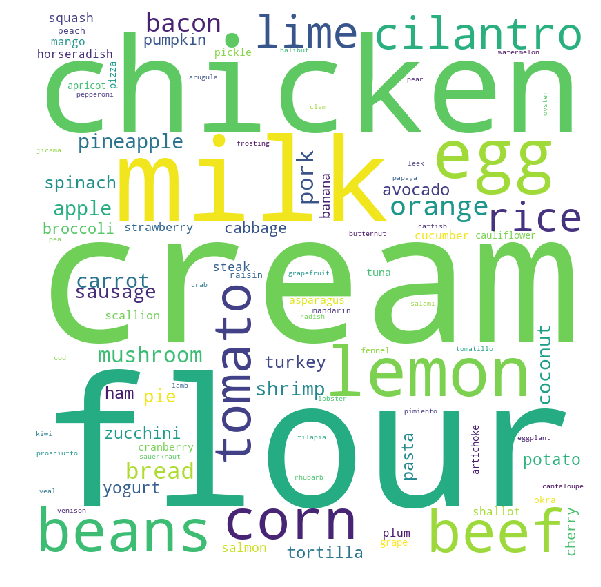

In [92]:
plt_wordcloud(data)

#### Chineses' popular ingredients for cooking

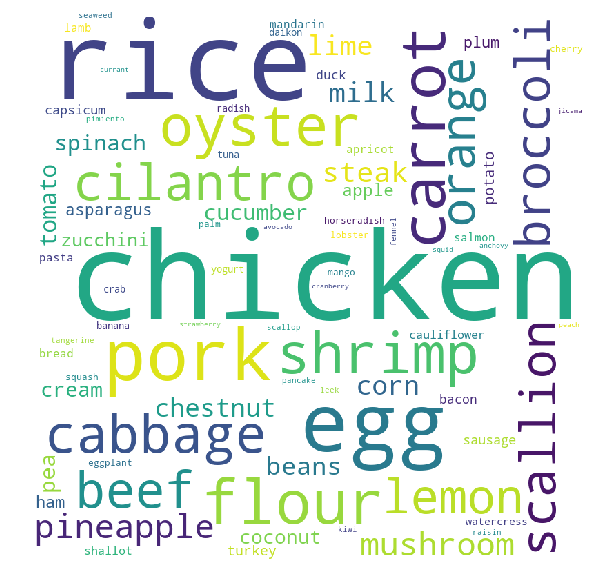

In [94]:
data = recipe_main[recipe_main['country'] == 'China']['ingredients'].values
plt_wordcloud(data)

The wordclouds shown above seem to make sense. Rice is popular in asian areas like China. Milk and beans are popular choices for meals in America. Yet in China these two are seldomly used for cooking. Pizza, as a total western food, does not appear in the top 50 frequently used ingredients for Chinese.

# 2. Data cleaning of intereactions and information retrieval

Then we load the interactions dataset which contain the review of the users on the recipes and try to dig some interesting information

In [2]:
interactions = pd.read_csv('RAW_interactions.csv')

In [9]:
interactions.isnull().any()

user_id      False
recipe_id    False
date         False
rating       False
review        True
dtype: bool

In [10]:
interactions_df = interactions_df.dropna(axis=0)

## 2.1 How the features are related to each other?

Here we further try to get the relation between number of reviews and different features, we hope to see that recipes that are more time consuming receive less reviews since less people try them.

In [3]:
# Split the nutrition list
nutritions_list = ["calories", "total_fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]
recipes['nutrition'] = recipes['nutrition'].apply(ast.literal_eval)
recipes_df[nutritions_list] = pd.DataFrame(recipes_df.nutrition.values.tolist(), index=recipes_df.index)
recipes_df = recipes_df.drop(['nutrition'], axis=1)

In [ ]:
num_reviews_df = interactions.groupby('id').count()

In [17]:
# merge recipe dataset with interaction dataset
df = recipes_df.merge(num_reviews_df[['name']].copy(), left_on='id', right_on='id')\
               .rename(columns={'name_y': 'count'})[['count', 'minutes', 'n_steps', 'n_ingredients'] + nutritions_list]

In [18]:
df = df.rename(columns={'count': 'num_reviews'})

In [22]:
# the following two functions are from the internet to help plot the heatmaps
# https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

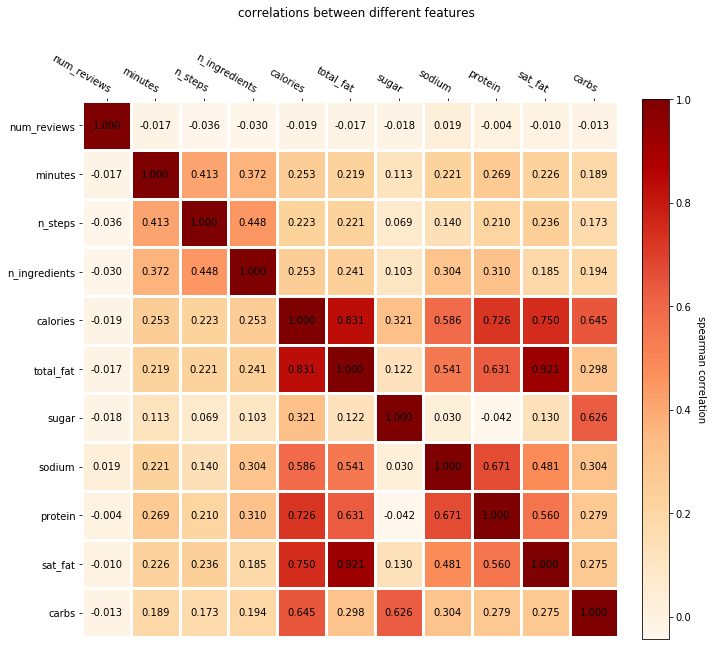

In [26]:
# Plotting setting
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('correlations between different features')        
im, cbar = heatmap(data=df.corr(method='spearman'), row_labels=df.columns, col_labels=df.columns, ax=ax,
                   cmap="OrRd", cbarlabel="spearman correlation")
texts = annotate_heatmap(im, valfmt="{x:.3f}", threshold=1)
fig.tight_layout()
plt.show()

We can see that the number of reviews has little to do with other features and it turns out to be somewhat random. In contrast, we find some strong correlation between different nutrition components in the recipe (e.g. total fat with calories(food with high fat usually has high calories), protein with calories, total fat with saturated fat, carbs with calories)

## 2.2 Get the taste of each recipe

To get an estimation of the taste of different dishes, we search for words indicating different types of taste in the tags, reviews and descriptions. Then we collect the taste of each recipe in sets and group them into a new column.

In [118]:
# Words for different taste catagory
taste_word_dict = {'sour': ['acid', 'acidic', 'sour', 'tart', 'vinegary', 'citrus', 'lemon'],
                   'bitter': ['bitter', 'harsh'],
                   'salty': ['brackish', 'salty', 'briny', 'saline'],
                   'sweet': ['dulcet', 'sweet', 'honeyed', 'dulcified', 'edulcorated', 'sweetened', 'candied','syrupy', 'sugarcoated', 'nectarous', 'candy', 'fudge'],
                   'spicy': ['spicy','peppery', 'piquant', 'pungent', 'burning', 'fiery', 'gingery', 'sharp', 'stinging', 'zesty', 'sugary', 'chili', 'chutneys', 'curries', 'peppers']}

In [119]:
# Take out the taste from tags, reviews and descriptions
for taste in taste_word_dict.keys():
    recipes = complete_df.review.str.lower().apply(lambda x: any(word in x for word in taste_word_dict[taste]))\
              | complete_df.tags.apply(lambda x: any(word in x for word in taste_word_dict[taste]))\
              | complete_df.description.str.lower().apply(lambda x: any(word in x for word in taste_word_dict[taste]))
    complete_df.taste.loc[recipes] = complete_df[recipes].taste.apply(lambda l:l + [taste])

/Users/jiahuawu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [120]:
taste_df = complete_df[complete_df.taste.apply(lambda l: len(l) > 0)].groupby(['id', 'name']).agg({'taste':'sum'})
taste_df['taste'] = taste_df['taste'].apply(set)

In [128]:
taste_recipes_df = taste_df.merge(recipes_df, left_on='id', right_on='id').drop('taste_y', axis=1).rename(columns={'taste_x': 'taste'})

After having obtained the taste of each recipe, we want to use the former country information to see the representative taste of recipes of each country in terms of count.

In [143]:
cols_to_use = recipes_country.columns.difference(taste_recipes_df.columns)
cols_list = cols_to_use.tolist()
cols_list.append('id')
cols_list.remove('nutrition')

In [145]:
taste_country = recipes_country_df[['continent', 'country', 'id']].merge(taste_recipes_df[['taste', 'id']], left_on='id', right_on='id')
taste_country.taste = taste_country.taste.apply(eval).apply(list)
best_taste_country_df = taste_country.explode('taste').groupby(['country', 'taste'])['id'].count()\
                        .groupby('country').nlargest(1).to_frame().droplevel(0).reset_index()
best_taste_country_df = best_taste_country_df.rename(columns={'id': 'count'})

## 2.3 Drawing the corresponding choropleth map

In [150]:
import geopandas
from matplotlib import cm
%matplotlib inline

In [151]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [152]:
invalid_indices = []
for ind, country in enumerate(best_taste_country_df.country):
    if country not in world.name.tolist():
        invalid_indices.append(ind)

In [155]:
best_taste_country_df = best_taste_country_df[~best_taste_country_df.country.isin(['Caribbean', 'Hawaii', 'Melanesia', 'Polynesia'])].reset_index(drop=True)

In [156]:
# Cleaning the error in spelling brought by the previous steps.
map_country_name = {'America': 'United States of America', 'Korea': 'South Korea', 'Lao':'Laos', 'Lybia': 'Libya',
                   'Melanesia': 'Malaysia', 'Morocca': 'Morocco', 'UK': 'United Kingdom'}

In [157]:
def helper(country):
    if country in map_country_name:
        return map_country_name[country]
    else:
        return country

In [158]:
best_taste_country_df.country = best_taste_country_df.country.apply(helper)

In [160]:
merged = world.set_index('name').join(best_taste_country_df.set_index('country'))
merged.drop('count', axis=1, inplace=True)
merged.taste = merged.taste.fillna('No Data')

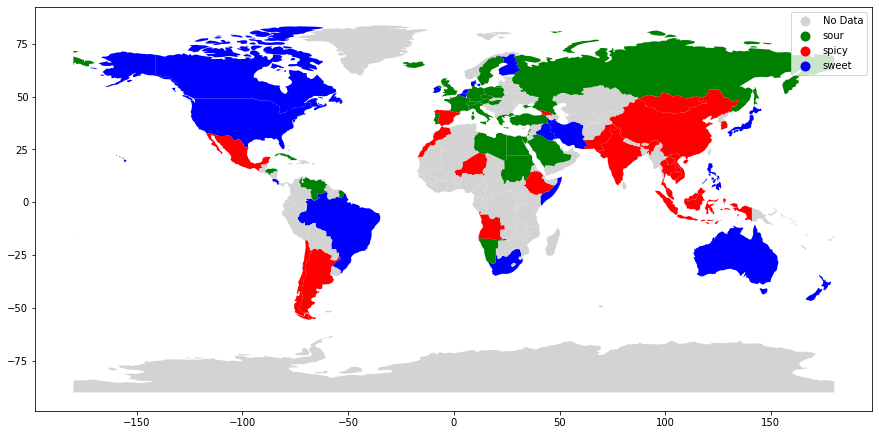

In [182]:
from matplotlib import colors
cmap = colors.ListedColormap(['lightgray', 'green', 'red', 'blue'])
merged.plot(column='taste', categorical=True, legend=True, figsize=(15,15), cmap=cmap)

We can see that spicy recipes are related to the southeast Asia, Mexico, India, China and Spain, which is in line with  common sense. Similarly, sweet recipes are related to north America, Oceania. What is surprising is the representative taste of the recipes of most of the european countries is sour.

## Annexe: Data preperation for later models

Here we scrape the data from food.com to complete the dose of each ingredient which is missing in the original dataset. We intend to use them to build a regression model capable of predicting the amount of nutrients based on the provided cooking method, ingredients and their amount. 

In [11]:
taste_recipes_df = pd.read_csv('recipe+taste.csv')

In [12]:
cooking_method_recipes_df = pd.read_pickle('recipe_cooking.pkl')

In [4]:
training_df = taste_recipes_df[['id', 'taste', 'ingredients', 
                                     'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'sat_fat', 'carbs']]\
                   .merge(cooking_method_recipes_df[['id', 'method', 'name']], left_on='id', right_on='id')

In [6]:
from recipe_scrapers import scrape_me

In [ ]:
ingredient_dict = {}
failed_url_list = []
counter = 0
for _, series in training_df.iterrows():
    if counter % 100 == 0:
        print('{} requests finished'.format(counter))
    recipe_id = series['id']
    recipe_name = series['name']
    url = 'https://www.food.com/recipe/{}{}?mode=Metric&scaleto=8'.format('-'.join(recipe_name.split()), '-'+str(recipe_id))
    scraper = scrape_me(url)
    if len(scraper.ingredients()) == 0:
        print(url)
        failed_url_list.append(url)
    else:
        ingredient_dict[recipe_id] = scraper.ingredients()
    counter += 1

# 3. Recommendation system based on matrix factorization
Up to now, we have preprocessed data and transfered dataset to sparse matrix.
We tried to take adavantage of Surprise library(http://surpriselib.com) to implement SGD optimization algorithm. But there is some underlying inconvenience with library.
Alternatively, we will try to reuse our made-from-sratch code from Machine Learning course, which is based on Alternating Least Squares(ALS) to solve optimization problem.

In [4]:
import scipy.sparse as sp
df = pd.read_csv('data/RAW_interactions.csv')

In [5]:
# remove invalid user and recipe
df = df[df['rating'] != 0]
min_num_ratings = 10
users_per_recipe_count = df.recipe_id.value_counts()
recipes_per_user_count = df.user_id.value_counts()

remaining_recipes = users_per_recipe_count[users_per_recipe_count > min_num_ratings].index.values
remaining_users = recipes_per_user_count[recipes_per_user_count > min_num_ratings].index.values

remaining_df = df[df['user_id'].isin(remaining_users) & df['recipe_id'].isin(remaining_recipes)]
remaining_df.head()

,user_id,recipe_id,date,rating,review
31,56680,79222,2006-11-11,5,"Oh, This was wonderful! Had a soup and salad ..."
43,183565,79222,2006-02-13,5,Wow! My family loves this recipe and it is a ...
44,101823,79222,2006-03-21,5,Excellent chowder. This was the perfect warm-...
46,446143,79222,2008-02-01,4,"Oh, how wonderful! I doubled the crab, and ad..."
47,226989,79222,2008-03-07,4,DH and I enjoyed this. However I used it only ...


In [6]:
'''
explorary analysis
remaining users and recipes which have number of ratings more than "min_num_ratings" 
'''
print(users_per_recipe_count[users_per_recipe_count > min_num_ratings].count())
print(recipes_per_user_count[recipes_per_user_count > min_num_ratings].count())

17552
11050


In [7]:
# reset user and recipe index
remaining_recipes = remaining_df.recipe_id.unique()
num_recipes = remaining_recipes.shape[0]
np.random.seed(123)
rand_index = np.random.permutation(num_recipes)
recipes_index_map = dict(zip(remaining_recipes, rand_index))

remaining_users = remaining_df.user_id.unique()
num_users = remaining_users.shape[0]
np.random.seed(456)
rand_index = np.random.permutation(num_users)
users_index_map = dict(zip(remaining_users, rand_index))

In [8]:
# collect row-col-value pairs
triple_pairs = pd.DataFrame()
triple_pairs['col_user'] = remaining_df.user_id.map(users_index_map)
triple_pairs['row_recipe'] = remaining_df.recipe_id.map(recipes_index_map)
triple_pairs['value_rating'] = remaining_df.rating
triple_pairs.head()

,col_user,row_recipe,value_rating
31,5015,7708,5
43,7618,7708,5
44,8810,7708,5
46,9060,7708,4
47,4886,7708,4


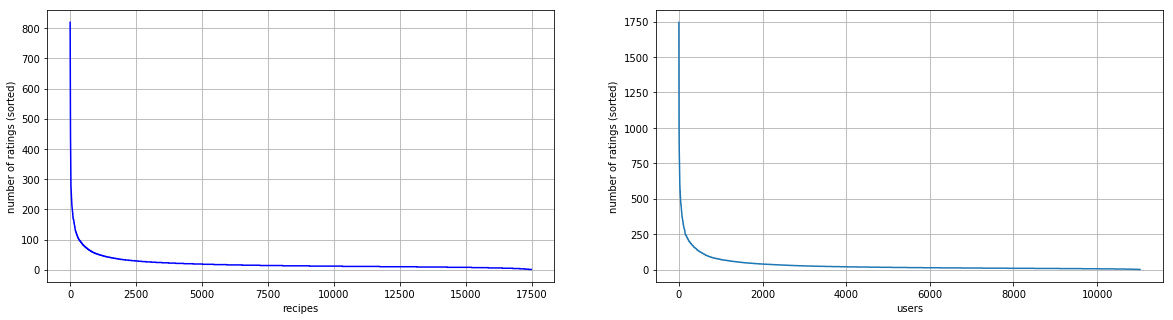

In [9]:
# plot the nubmer of ratings per recipe and the nubmer of ratings per user
sorted_num_users_per_recipe = triple_pairs['row_recipe'].value_counts()
sorted_num_recipes_per_user = triple_pairs['col_user'].value_counts()

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(range(num_recipes), sorted_num_users_per_recipe.values, color='blue')
ax1.set_xlabel("recipes")
ax1.set_ylabel("number of ratings (sorted)")
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(range(num_users), sorted_num_recipes_per_user.values)
ax2.set_xlabel("users")
ax2.set_ylabel("number of ratings (sorted)")
ax2.grid()

In [10]:
# create sparse matrix
def proprecess():
    ratings = sp.lil_matrix((num_recipes, num_users))
    for _, line in triple_pairs.iterrows():
        ratings[line['row_recipe'], line['col_user']] = line['value_rating']
    return ratings
ratings = proprecess()
ratings

<17489x11026 sparse matrix of type '<class 'numpy.float64'>'
	with 357256 stored elements in LInked List format>

In [11]:
print(
        'Matrix sparsity: %.2f%%' 
        % (100 * ratings.nnz / (ratings.shape[0] * ratings.shape[1]))
)

Matrix sparsity: 0.19%


### Plan A: solution based on Surprise library

In [12]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader

from surprise.model_selection import cross_validate

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(triple_pairs[['col_user', 'row_recipe', 'value_rating']], reader)

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5655  0.5655  0.5646  0.5695  0.5679  0.5666  0.0018  
MAE (testset)     0.3580  0.3570  0.3574  0.3598  0.3588  0.3582  0.0010  
Fit time          18.03   17.55   17.08   16.61   16.84   17.22   0.51    
Test time         0.81    0.61    0.60    0.60    0.56    0.64    0.09    


{'test_rmse': array([0.56547348, 0.56553009, 0.56463639, 0.56949587, 0.56791957]),
 'test_mae': array([0.35799644, 0.35703362, 0.35744299, 0.35984545, 0.3588221 ]),
 'fit_time': (18.028543949127197,
  17.551138877868652,
  17.07676911354065,
  16.60608696937561,
  16.83831286430359),
 'test_time': (0.8137021064758301,
  0.6058290004730225,
  0.5997560024261475,
  0.5984840393066406,
  0.5598690509796143)}

### Plan B: solution based on Machine Learning course code

In [13]:
# utilities function, which will be moved to helpers.py file

def split_data(ratings, p_test=0.1, seed=988):
    """Split the data in training and test sets."""
    np.random.seed(seed)

    n_users = ratings.shape[1]

    test = sp.lil_matrix(ratings.shape)
    train = ratings.copy()

    for user in range(n_users):
        nb_ratings = len(ratings[:, user].nonzero()[0])
        test_ratings = np.random.choice(
            ratings[:, user].nonzero()[0],
            size=int(p_test * nb_ratings),
            replace=False
        )
        for index in range(test_ratings.shape[0]):
            train[index, user] = 0
            test[index, user] = ratings[index, user]

    print('Number of ratings : %d' % ratings.nnz)
    print('Number of train ratings : %d' % train.nnz)
    print('Number of test ratings : %d' % test.nnz)

    return train, test

In [ ]:
train, test = split_data(ratings, p_test=0.1)

In [ ]:
# still waited to implement and check
X, X_train, y_train, X_test, y_test = get_ALS_predictions(
    ratings,
    train,
    test,
    n_features_array=range(10,11),
    lambda_user=0.2,
    lambda_item=0.02
)